<a href="https://colab.research.google.com/github/ArnoSchiller/AutoML/blob/dev/SWMS_lstm_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Define parameters

In [ ]:
# Select measurements 
measurements = []

## tank group measurements 
prefix = "mean_"
tank_group = 1
for k in [1,2,3]:
    measurements.append(prefix + "sensor.o2.becken" + str(tank_group) + str(k))
    measurements.append(prefix + "sensor.temp.becken" + str(tank_group) + str(k))
if tank_group < 3:
    measurements.append(prefix + "sensor.ws.sedi" + str(tank_group))
else:
    measurements.append(prefix + "sensor.ws.sed" + str(tank_group))
measurements.append(prefix + "sensor.ws.bio" + str(tank_group))
measurements.append(prefix + "allgemein_var.display_kollektor.leistung_p1" + str(tank_group))


mqtt_addition = "tank_group=" + str(tank_group)

In [ ]:

#@title Datenbank und Messreihenauswahl
database = 'plc' #@param ["plc", "edge", "_internal", "InfluxDB_dev","profec_test"]

#measurement = 'sensor.o2.becken12' #@param ["sensor.feuchte_relativ.aussen", "sensor.o2.becken12"] {allow-input: true}

#train_min_time = '2021-10-07' #@param {type:"date"}
train_max_time = '2021-10-03' #@param {type:"date"}
train_duration = '23d' #@param {type:"string"}

test_min_time = '2021-09-01' #@param {type:"date"}
test_max_time = '2022-01-04' #@param {type:"date"}
#test_duration = '19d' #@param {type:"string"}
#### fds
group_by = '5m' #@param {type:"string"}

In [ ]:
#@title Model parameters
model_name = "autoencoder_tg1_2"   #@param ["lstm_autoencoder_1"] {allow-input: true}

epochs = 100            #@param {type:"integer"}
batch_size = 32         #@param {type:"integer"}
window_length = 12 * 24      #@param {type:"integer"}
sequence_length = '1d'
sequence_step = '1d'

print("Database:", database)
print("Measurements:", measurements)
#print("Training:   From", train_min_time, "to", train_max_time)
#print("Testing:    From", test_min_time, "to", test_max_time)
print("Model:", model_name, ", window_length:", window_length)


Database: plc
Measurements: ['mean_sensor.o2.becken11', 'mean_sensor.temp.becken11', 'mean_sensor.o2.becken12', 'mean_sensor.temp.becken12', 'mean_sensor.o2.becken13', 'mean_sensor.temp.becken13', 'mean_sensor.ws.sedi1', 'mean_sensor.ws.bio1', 'mean_allgemein_var.display_kollektor.leistung_p11']
Model: autoencoder_tg1_2 , window_length: 288


## Connect to google drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/My Drive/TimeSeriesAnalysis/
%ls

Mounted at /content/gdrive
/content/gdrive/My Drive/TimeSeriesAnalysis
autoencoder_tg1_1/  lstm_autoencoder_1/          training_data.csv
autoencoder_tg1_2/  SWMS_lstm_autoencoder.ipynb  validation_data.csv


## Define functions for data loading

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def generate_datasets_for_training(data, window_size,scale=True, scaler_type=StandardScaler):
    _l = len(data) 
    data = scaler_type().fit_transform(data)
    Xs = []
    Ys = []
    for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
        Xs.append(data[i:i+window_size])
        Ys.append(data[i:i+window_size])
    tr_x, ts_x, tr_y, ts_y = [np.array(x) for x in train_test_split(Xs, Ys)]
    assert tr_x.shape[2] == ts_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
    return  (tr_x.shape[2], tr_x, tr_y, ts_x, ts_y)


def generate_datasets_for_validation(data, window_size,scale=True, scaler_type=StandardScaler):
    _l = len(data) 
    data = scaler_type().fit_transform(data)
    Xs = []
    Ys = []
    for i in range(0, (_l - window_size)):
    # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
        Xs.append(data[i:i+window_size])
        Ys.append(data[i:i+window_size])
    tr_x, ts_x, tr_y, ts_y = [np.array(x) for x in train_test_split(Xs, Ys, test_size=0.99)]
    assert tr_x.shape[2] == ts_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
    return  (tr_x.shape[2], tr_x, tr_y, ts_x, ts_y)

## Load data from file

In [ ]:
import pandas as pd
import numpy as np

train_data = pd.read_csv("training_data.csv")
train_data = train_data.drop("time",axis=1)
train_data.head()

test_data = pd.read_csv("validation_data.csv")
test_data = test_data.drop("time", axis=1)
test_data.head()

,mean_allgemein_var.display_kollektor.leistung_p11,mean_allgemein_var.display_kollektor.leistung_p12,mean_allgemein_var.display_kollektor.leistung_p13,mean_sensor.Volumenstrom.verdichter,mean_sensor.druck.verdichter,mean_sensor.druck.verdichter_leitungsende,mean_sensor.feuchte_relativ.aussen,mean_sensor.feuchte_relativ.halle_hinten,mean_sensor.feuchte_relativ.halle_vorn,mean_sensor.o2.becken11,mean_sensor.o2.becken12,mean_sensor.o2.becken13,mean_sensor.o2.becken21,mean_sensor.o2.becken22,mean_sensor.o2.becken23,mean_sensor.o2.becken31,mean_sensor.o2.becken32,mean_sensor.o2.becken33,mean_sensor.temp.becken11,mean_sensor.temp.becken12,mean_sensor.temp.becken13,mean_sensor.temp.becken21,mean_sensor.temp.becken22,mean_sensor.temp.becken23,mean_sensor.temp.becken31,mean_sensor.temp.becken32,mean_sensor.temp.becken33,mean_sensor.temp.halle_gesamt_mittelwert,mean_sensor.temp.halle_hinten,mean_sensor.temp.halle_vorn,mean_sensor.temp.luft_aussen,mean_sensor.temp.pl11,mean_sensor.temp.pl12,mean_sensor.temp.pl21,mean_sensor.temp.pl22,mean_sensor.temp.vorlauf_heizung,mean_sensor.truebung.storage,mean_sensor.ws.bio1,mean_sensor.ws.bio2,mean_sensor.ws.bio3,mean_sensor.ws.pl11,mean_sensor.ws.pl12,mean_sensor.ws.pl21,mean_sensor.ws.pl22,mean_sensor.ws.reservoir,mean_sensor.ws.sed3,mean_sensor.ws.sedi1,mean_sensor.ws.sedi2,mean_sensor.ws.storage_kollektor
0,59.0,56.0,49.0,737.267200,0.409997,0.410973,0.837752,0.852396,0.836157,6.260672,6.141230,0.0,6.692525,6.458651,6.379241,6.687549,0.0,6.469140,29.507230,28.920880,9999.0,28.945530,28.919940,29.049360,29.005780,9999.0,28.994700,29.177380,29.391350,28.964380,13.258530,28.86397,28.703390,28.33665,28.078410,37.500000,210.09800,2.288115,2.59943,2.602882,0.028572,0.034359,-0.017360,0.052805,0.183732,2.690661,2.353217,2.721404,0.399653
1,59.0,56.0,49.0,737.122887,0.409994,0.410976,0.837217,0.852399,0.835894,6.266599,6.141356,0.0,6.685192,6.468863,6.369840,6.681170,0.0,6.468895,29.507293,28.920849,9999.0,28.946653,28.920045,29.049683,29.006269,9999.0,28.994939,29.184094,29.391471,28.977641,13.248451,28.86397,28.702377,28.33665,28.076385,37.493333,209.70016,2.290936,2.59943,2.602954,0.028597,0.034383,-0.017336,0.052805,0.183732,2.690733,2.354447,2.722224,0.404379
2,59.0,56.0,49.0,736.978573,0.409992,0.410978,0.836681,0.852401,0.835631,6.272525,6.141482,0.0,6.677859,6.479075,6.360439,6.674791,0.0,6.468649,29.507357,28.920817,9999.0,28.947777,28.920149,29.050005,29.006759,9999.0,28.995179,29.190808,29.391591,28.990903,13.238373,28.86397,28.701365,28.33665,28.074359,37.486667,209.30232,2.293757,2.59943,2.603027,0.028621,0.034408,-0.017312,0.052805,0.183732,2.690806,2.355676,2.723044,0.409105
3,59.0,56.0,49.0,736.834260,0.409989,0.410981,0.836146,0.852403,0.835368,6.278452,6.141608,0.0,6.670526,6.489288,6.351038,6.668412,0.0,6.468404,29.507420,28.920786,9999.0,28.948900,28.920254,29.050328,29.007248,9999.0,28.995418,29.197522,29.391712,29.004164,13.228294,28.86397,28.700352,28.33665,28.072334,37.480000,208.90448,2.296578,2.59943,2.603099,0.028645,0.034432,-0.017288,0.052805,0.183732,2.690878,2.356906,2.723863,0.413831
4,59.0,56.0,49.0,736.689947,0.409987,0.410983,0.835611,0.852406,0.835106,6.284379,6.141735,0.0,6.663193,6.499500,6.341637,6.662033,0.0,6.468158,29.507483,28.920755,9999.0,28.950023,28.920359,29.050651,29.007737,9999.0,28.995657,29.204236,29.391833,29.017425,13.218215,28.86397,28.699339,28.33665,28.070309,37.473333,208.50664,2.299399,2.59943,2.603171,0.028669,0.034456,-0.017264,0.052805,0.183732,2.690950,2.358136,2.724683,0.418556


## Load data from Influx DB

In [ ]:
!pip3 install influxdb
from influxdb import InfluxDBClient, DataFrameClient

from datetime import datetime, timedelta
import pandas as pd
import re

     |████████████████████████████████| 77 kB 4.2 MB/s 


In [ ]:
def parse_time(time_str):
    regex = re.compile(r'((?P<days>\d+?)d)?((?P<hours>\d+?)h)?((?P<minutes>\d+?)m)?((?P<seconds>\d+?)s)?((?P<milliseconds>\d+?)ms)?')
    parts = regex.match(time_str)
    if not parts:
        return
    parts = parts.groupdict()
    time_params = {}
    for name, param in parts.items():
        if param:
            time_params[name] = int(param)
    return timedelta(**time_params)

        
def get_latest_value_from_influxDB(measurements, database, min_time_ms):
    q = 'SELECT mean(*) FROM {db} WHERE time < {min_time}ms GROUP BY * ORDER BY DESC LIMIT 1'.format(
        db = database,
        min_time = min_time_ms)
    data = pd.DataFrame(client.query(q).get_points())
    # set timestamp to index
    data.set_index('time', drop=True, inplace=True)
    data = data[measurements]

    return data    
        
def get_data_from_influxDB(measurements, database, min_time_ms, max_time_ms, group_by):
    q = 'SELECT mean(*) FROM {db} WHERE time >= {min_time}ms AND time < {max_time}ms GROUP BY time({gb}) fill(previous)'.format(
        db = database,
        min_time = min_time_ms,
        max_time = max_time_ms,
        gb = group_by)
    #print(q)
    data = pd.DataFrame(client.query(q).get_points())
    #print(data)
    if(data.empty):
        return None
    
    #print(data)
    # set timestamp to index
    data.set_index('time', drop=True, inplace=True)
    data = data[measurements]

    #print("Total values NaN", data.isna().values.sum())
    #print(data.isna().index.all())
    
    last_val = get_latest_value_from_influxDB(measurements, database, min_time_ms)

    row_idx = 0
    while row_idx < len(data.index):
        row = data.iloc[row_idx]
        values_nan = row.isna().values.sum()

        if values_nan > 0:
            #print("Values NaN in row", row_idx, ":", values_nan)
            nan_idx = row.isna().index
            for idx in nan_idx:
                data.loc[data.index[row_idx], idx] = last_val.loc[last_val.index[0], idx]
        else: 
            #print("Total values NaN after adding latest values", data.isna().values.sum())
            break
        row_idx += 1

    #print(data.columns)
    #print(data)

    return data    

def convert_data_to_numpy(data):
    return data.to_numpy()

In [ ]:
#train_min_time_ms = int(datetime.fromisoformat(train_min_time).timestamp() * 1000)
train_max_time_ms = datetime.fromisoformat(train_max_time)
train_min_time_ms = int((train_max_time_ms - parse_time(train_duration)).timestamp() * 1000)
train_max_time_ms = int(train_max_time_ms.timestamp() * 1000)

test_min_time_ms = int(datetime.fromisoformat(test_min_time).timestamp() * 1000)
test_max_time_ms = datetime.fromisoformat(test_max_time)
#test_min_time_ms = int((test_max_time_ms - parse_time(test_duration)).timestamp() * 1000)
test_max_time_ms = int(test_max_time_ms.timestamp() * 1000)

client = InfluxDBClient(host='demo2.iotstack.co', port=8086, 
                        username="telegraf", password="tiguitto", 
                        ssl=True, verify_ssl=True)
client.switch_database(database)

In [ ]:
train_data = convert_data_to_numpy(get_data_from_influxDB(measurements=measurements,
                                                          database=database,
                                                          min_time_ms=train_min_time_ms,
                                                          max_time_ms=train_max_time_ms,
                                                          group_by=group_by))

print(train_data.size)
print('\n'*2, '#'*100,'\n'*2)

test_data = convert_data_to_numpy(get_data_from_influxDB(measurements=measurements,
                                                          database=database,
                                                          min_time_ms=test_min_time_ms,
                                                          max_time_ms=test_max_time_ms,
                                                          group_by=group_by))
print(test_data.size)

59616


 #################################################################################################### 


324000


## Build, train and save the model 

Source: https://towardsdatascience.com/using-lstm-autoencoders-on-multidimensional-time-series-data-f5a7a51b29a1

In [ ]:
from keras import metrics
import keras
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

feats, X, Y, XX, YY = generate_datasets_for_training(train_data, window_length)

model = keras.Sequential()
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
model.compile(loss="mse",optimizer='adam')
model.build()
print(model.summary())

history = model.fit(x=X, y=Y, validation_data=(XX, YY), epochs=epochs, batch_size=batch_size, shuffle=True) #, callbacks=[early_stop])
model.save(model_name, overwrite=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 288, 64)           18944     
                                                                 
 encoder_2 (LSTM)            (None, 288, 32)           12416     
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 encoder_decoder_bridge (Rep  (None, 288, 16)          0         
 eatVector)                                                      
                                                                 
 decoder_1 (LSTM)            (None, 288, 16)           2112      
                                                                 
 decoder_2 (LSTM)            (None, 288, 32)           6272      
                                                        

INFO:tensorflow:Assets written to: autoencoder_tg1_2/assets


INFO:tensorflow:Assets written to: autoencoder_tg1_2/assets


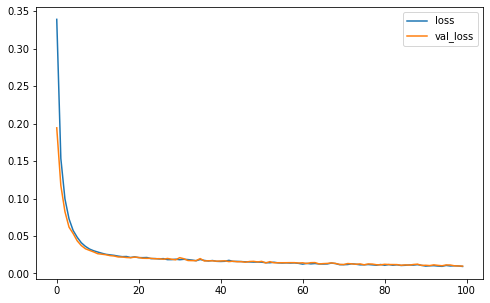

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

## Load model from file and run on data


In [ ]:
client = InfluxDBClient(host='demo2.iotstack.co', port=8086, 
                        username="telegraf", password="tiguitto", 
                        ssl=True, verify_ssl=True)
client.switch_database(database)

from sklearn.preprocessing import StandardScaler
def prepare_data_for_model(data, scale=True, scaler_type=StandardScaler):
    data = scaler_type().fit_transform(data)
    #if len(data) > sequence_length:
    #    data = data[-sequence_length:-1]
    
    Xs = []
    Xs.append(data)
    return np.array(Xs)


mse = keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)

def collect_data_and_run_model(model, timestamp, sequence_length, group_by):
    max_time = int(timestamp.timestamp() * 1000)
    min_time = int((timestamp - parse_time(sequence_length)).timestamp() * 1000)
    data = get_data_from_influxDB(measurements, 'plc', min_time, max_time, group_by)

    if data is None:
        return -1

    data = data.to_numpy()
    np.reshape(data, (1, data.shape[0], data.shape[1]))

    data = prepare_data_for_model(data)
    
    res = model.predict(data)
    loss = mse(data, res).numpy()

    return loss


!pip install paho-mqtt
import paho.mqtt.client as mqtt

mqtt_host                = "demo2.iotstack.co"
mqtt_user_name           = "pubclient"
mqtt_password            = "tiguitto"
mqtt_port                = 8883
mqtt_keepalive           = 60

mqtt_client = mqtt.Client()
mqtt_client._username = mqtt_user_name
mqtt_client._password = mqtt_password
mqtt_client.tls_set()
mqtt_client.connect(mqtt_host, mqtt_port, mqtt_keepalive)

def get_influx_ts(ts):
    base_ts = datetime(1677, 9, 21, 0, 12, 43, 145224)
    base_ns = -9223372036854775806

    delta_ts = ts - base_ts
    delta_ns = delta_ts.total_seconds()*1000000000
    
    ts_ns = base_ns + delta_ns

    return "{:.0f}".format(ts_ns)

def send_result_mqtt(timestamp, tag_addition, loss, model_name, sequence_length, group_by, sequence_step):
    ts = get_influx_ts(timestamp)

    msg = "evaluation"
    msg += ","

    msg += tag_addition
    msg += ","

    msg += "model_name="
    msg += model_name
    msg += ","
    msg += "sequence_length="
    msg += sequence_length
    msg += ","
    msg += "group_by="
    msg += group_by
    msg += ","
    msg += "sequence_step="
    msg += sequence_step
    
    msg += " "
    msg += "loss="
    msg += str(loss)
    
    msg += " "
    msg += str(ts)
    print(msg)

    mqtt_client.publish("IOT/test", msg)

In [ ]:
reconstructed_model = keras.models.load_model(model_name)
reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 288, 64)           18944     
                                                                 
 encoder_2 (LSTM)            (None, 288, 32)           12416     
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 encoder_decoder_bridge (Rep  (None, 288, 16)          0         
 eatVector)                                                      
                                                                 
 decoder_1 (LSTM)            (None, 288, 16)           2112      
                                                                 
 decoder_2 (LSTM)            (None, 288, 32)           6272      
                                                        

In [ ]:
timestamp = datetime.fromisoformat('2021-09-01+00:00') # ('2022-01-01')

while(timestamp < datetime.fromisoformat('2022-01-05')):
    loss = collect_data_and_run_model(reconstructed_model, timestamp, sequence_length, group_by)
    print(timestamp, " - ", loss)
    send_result_mqtt(timestamp, mqtt_addition, loss, model_name, sequence_length, group_by, sequence_step)
    timestamp += parse_time(sequence_step)

2021-09-01 00:00:00  -  -1
evaluation,tank_group=1,model_name=autoencoder_tg1_2,sequence_length=1d,group_by=5m,sequence_step=1d loss=-1 1630454400000000000
2021-09-02 00:00:00  -  -1
evaluation,tank_group=1,model_name=autoencoder_tg1_2,sequence_length=1d,group_by=5m,sequence_step=1d loss=-1 1630540800000000000
2021-09-03 00:00:00  -  -1
evaluation,tank_group=1,model_name=autoencoder_tg1_2,sequence_length=1d,group_by=5m,sequence_step=1d loss=-1 1630627200000000000
2021-09-04 00:00:00  -  -1
evaluation,tank_group=1,model_name=autoencoder_tg1_2,sequence_length=1d,group_by=5m,sequence_step=1d loss=-1 1630713600000000000
2021-09-05 00:00:00  -  -1
evaluation,tank_group=1,model_name=autoencoder_tg1_2,sequence_length=1d,group_by=5m,sequence_step=1d loss=-1 1630800000000000000
2021-09-06 00:00:00  -  1.025598
evaluation,tank_group=1,model_name=autoencoder_tg1_2,sequence_length=1d,group_by=5m,sequence_step=1d loss=1.025598 1630886400000000000
2021-09-07 00:00:00  -  1.0659449
evaluation,tank_gr

In [ ]:
feats, _, _, XX, YY = generate_datasets_for_validation(test_data, window_length)
eval = model.evaluate(x=XX, y=YY, batch_size=batch_size, return_dict=True)

845/845 [==============================] - 35s 42ms/step - loss: 0.6384


In [ ]:
feats, X, Y, XX, YY = generate_datasets_for_training(train_data, window_length)
eval = model.evaluate(x=XX, y=YY, batch_size=batch_size, return_dict=True)

158/158 [==============================] - 7s 42ms/step - loss: 0.1220


In [ ]:
val = XX[0:59]
val_pred = model.predict(XX, batch_size=batch_size)
#print(val_pred)

mse = keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
loss = mse(XX, val_pred).numpy()

In [ ]:
l = np.mean(loss,axis=1)
print(l.shape)
print(l)

(5025,)
[0.14081083 0.05040515 0.05924203 ... 0.09286948 0.09163727 0.06387298]


In [ ]:
mse = keras.losses.MeanSquaredError()
mse(val, val_pred).numpy()

0.08521775

In [ ]:
mse = keras.losses.MeanSquaredError()
for i in range(0, len(XX)-60):
    val = XX[i:i+59]
    val_pred = model.predict(val, batch_size=batch_size)
    e = mse(val, val_pred).numpy()
    print(e)

0.08521775
0.08382894
0.083848566
0.08469069
0.084640406
0.08465851
0.084799886
0.085361406
0.08993405
0.08883081
0.08994052
0.09011304
0.0900291
0.091042876
0.08940987
0.08883122
0.088545345
0.0882771


KeyboardInterrupt: ignored

In [ ]:
print(len(XX), XX[0].size, XX.size)

5025 2940 14773500
